In [1]:
import cv2
import os.path as osp
import numpy as np
import torch
import imageio.v3 as iio

from moduv.utils import read_img, visualize_ann, vis_2d, show_vis
from moduv.model import Model

/home/ys732/.conda/envs/move/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Visualizing Predictions at Each Stage of Self-Training (Reproducing Fig. 1)
- **M2M only**: After Moving2Mobile 
- **L2S:L only**: After Large2Small, Large Object Detector
- **L2S:S only**: After Large2Small, Small Object Detector
- **Final**: After Final Round of Self-Training

Loading mrcnn weights from ./ckpts/moduv_m2m.pth ...
Loading mrcnn weights from ./ckpts/moduv_l2s_l.pth ...
Loading mrcnn weights from ./ckpts/moduv_l2s_s.pth ...
Loading mrcnn weights from ./ckpts/moduv_final.pth ...


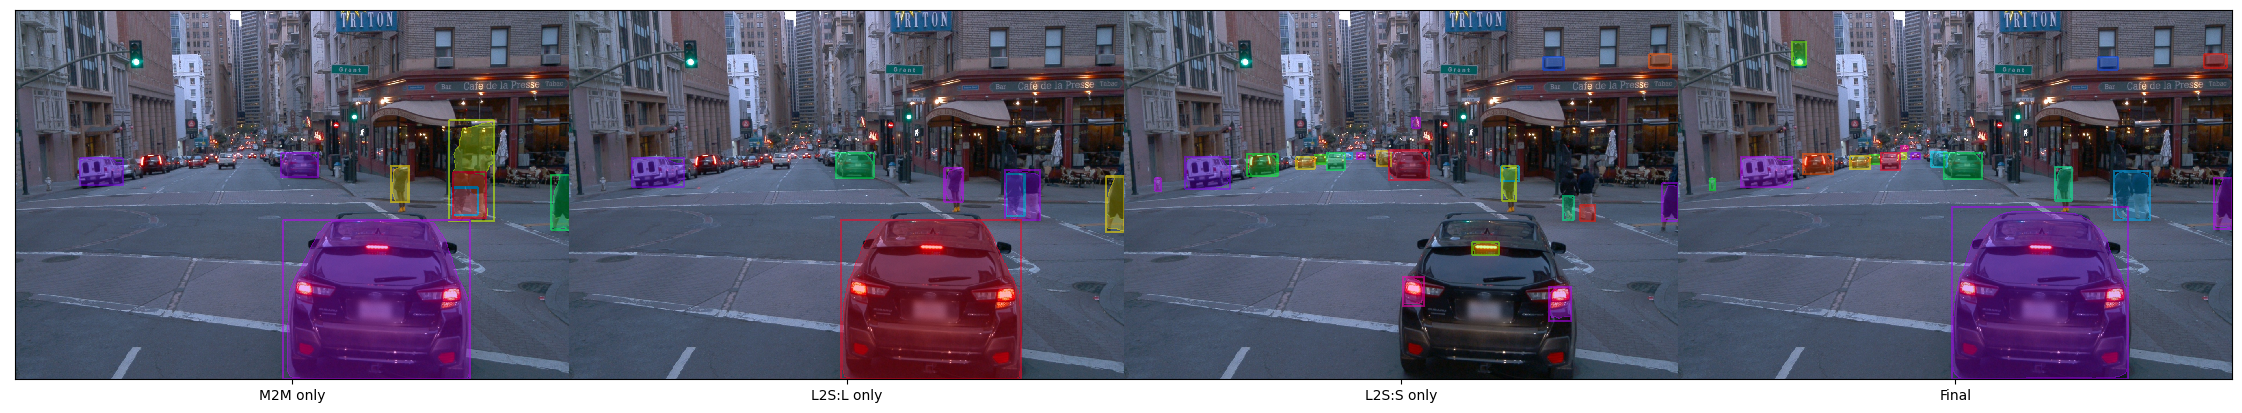

In [2]:
models = [
    {'path': './ckpts/moduv_m2m.pth', 'name': 'M2M only'},
    {'path': './ckpts/moduv_l2s_l.pth', 'name': 'L2S:L only'},
    {'path': './ckpts/moduv_l2s_s.pth', 'name': 'L2S:S only'},
    {'path': './ckpts/moduv_final.pth', 'name': 'Final'},
]

demo_img_path = './data/waymo/val/segment-17694030326265859208_2340_000_2360_000/000034.jpg'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model(backbone_weights='scratch').eval().to(device)
visuals = list()
for m in models:
    model.load(m['path'])
    with torch.no_grad():
        output = model(read_img(demo_img_path))[0]
    vis = visualize_ann(iio.imread(demo_img_path), output[0], bool_words=False)
    visuals.append(vis)
model = None
show_vis(visuals, [m['name'] for m in models])

### Visualizing Pseudo-Label Generation (Reproducing Fig. 2)

In [3]:
train_instance = 'train/segment-1255991971750044803_1700_000_1720_000 45'
segment_name, frame_idx = train_instance.split(); frame_idx = int(frame_idx)
img_path = osp.join('./data/waymo', segment_name, f'{frame_idx:06}.jpg')
img = iio.imread(img_path)      # (1280, 1920, 3)

#### Computing $L_i^{(0)}$ from motion segmentation and monocular depth

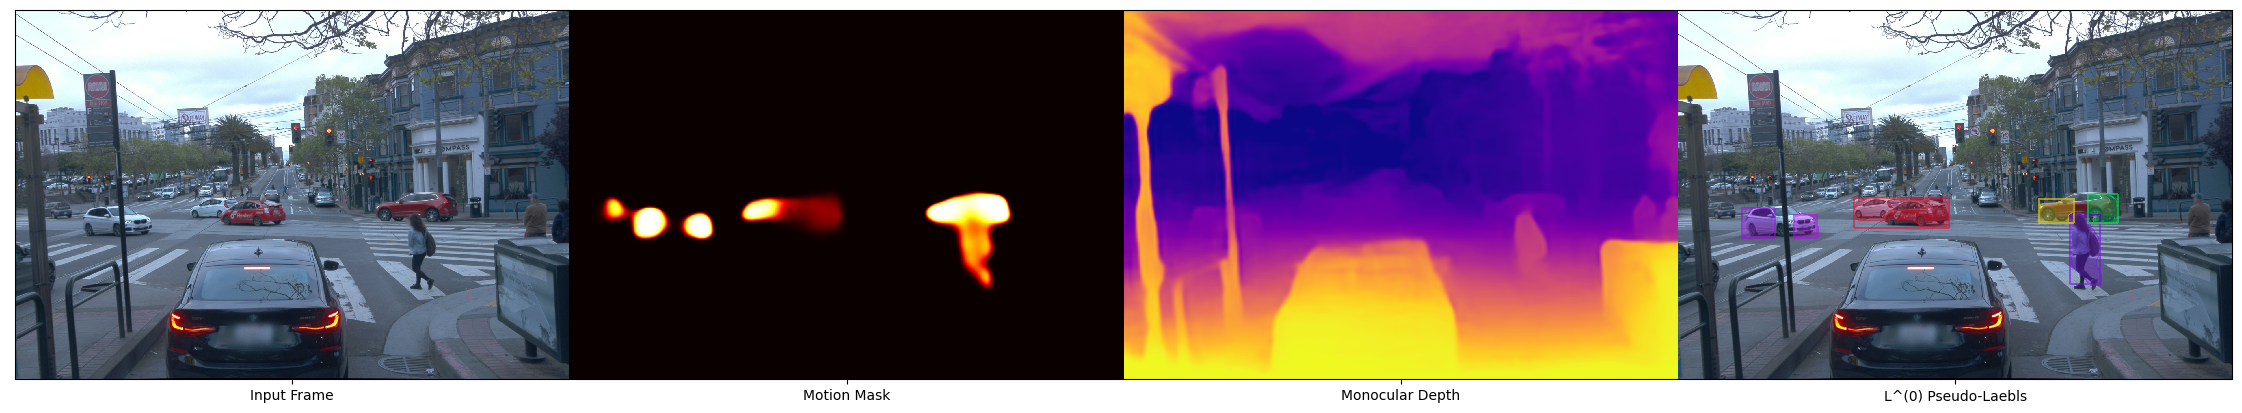

In [4]:
import warnings
from sklearn.exceptions import EfficiencyWarning
warnings.simplefilter(action='ignore', category=EfficiencyWarning)
from moduv.pseudo_labels.init_labels import MaskExtractor

# Load Motion Mask, Depth, K inverse
dynamo_load_path = osp.join('./save/dynamo_out-waymo', segment_name, f'{frame_idx:06}.npz')
dynamo_out = np.load(dynamo_load_path)
mask =  dynamo_out['mot_mask']  # (320, 480)
depth = dynamo_out['depth']     # (320, 480)
inv_K = dynamo_out['inv_K']     # (4, 4)

# Compute L0
mask_extractor = MaskExtractor(nbh_size=10, mot_thrd=0.1, eps=0.03, minsamp=100, height=mask.shape[0], width=mask.shape[1])
L0 = mask_extractor.extract(torch.from_numpy(mask), torch.from_numpy(depth)[None, None], torch.from_numpy(inv_K)[None])

mask_vis = cv2.resize(vis_2d(mask, 'hot', vminmax=[0,1]), img.shape[:2][::-1])
depth_vis = cv2.resize(vis_2d(1/depth), img.shape[:2][::-1])    # visualizing disparity
L0_vis = visualize_ann(img, L0, bool_words=False)
show_vis([img, mask_vis, depth_vis, L0_vis], ['Input Frame', 'Motion Mask', 'Monocular Depth', 'L^(0) Pseudo-Laebls'])



#### Computing $L_i^{(1)}$ via detector after Moving2Mobile self-training

Loading MoCov2 backbone from ./ckpts/moco_v2_800ep_pretrain.pth.tar ...
Loading mrcnn weights from ./ckpts/moduv_m2m.pth ...


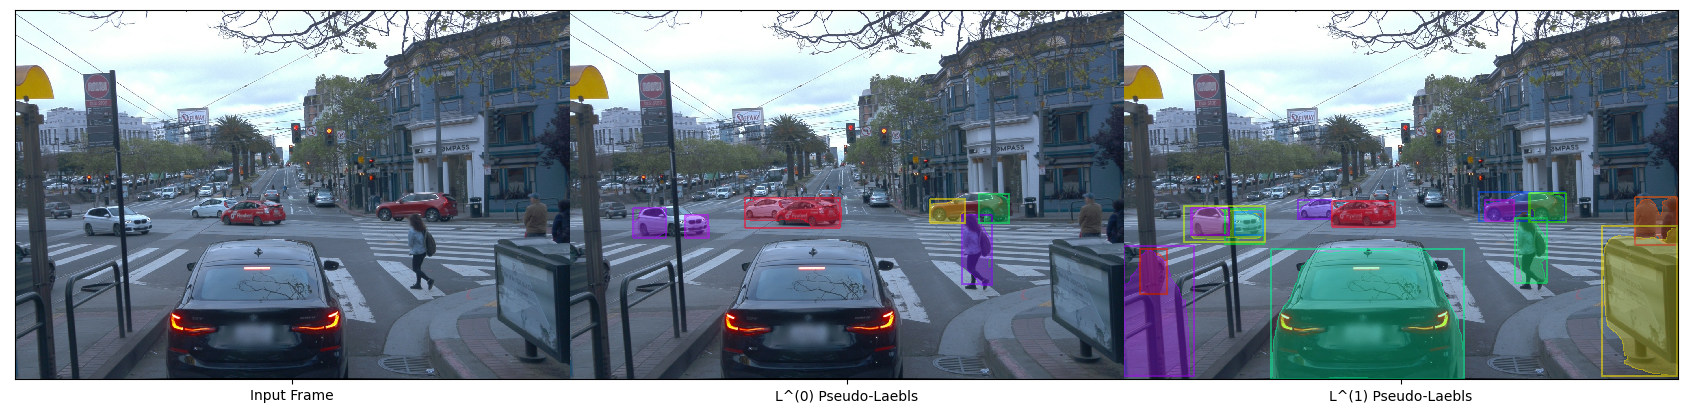

In [5]:
from moduv.pseudo_labels.save_pred import get_pseudo_labels

ST_CONF_THRD = 0.5  # confidence threshold for self training

# Load model after Moving2Mobile self-training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model(backbone_weights='moco').eval().to(device)
model.load('./ckpts/moduv_m2m.pth')
model.set_score_thrd(ST_CONF_THRD)

# Compute L1
with torch.no_grad():
    output = model(read_img(img_path))[0][0]
L1 = get_pseudo_labels(output)
L1_vis = visualize_ann(img, L1, bool_words=False)
show_vis([img, L0_vis, L1_vis], ['Input Frame', 'L^(0) Pseudo-Laebls', 'L^(1) Pseudo-Laebls'])

#### Computing $L_i^{(2)}$ via detector after Large2Small self-training

Loading MoCov2 backbone from ./ckpts/moco_v2_800ep_pretrain.pth.tar ...
Loading mrcnn weights from ./ckpts/moduv_l2s_l.pth ...
Loading MoCov2 backbone from ./ckpts/moco_v2_800ep_pretrain.pth.tar ...
Loading mrcnn weights from ./ckpts/moduv_l2s_s.pth ...


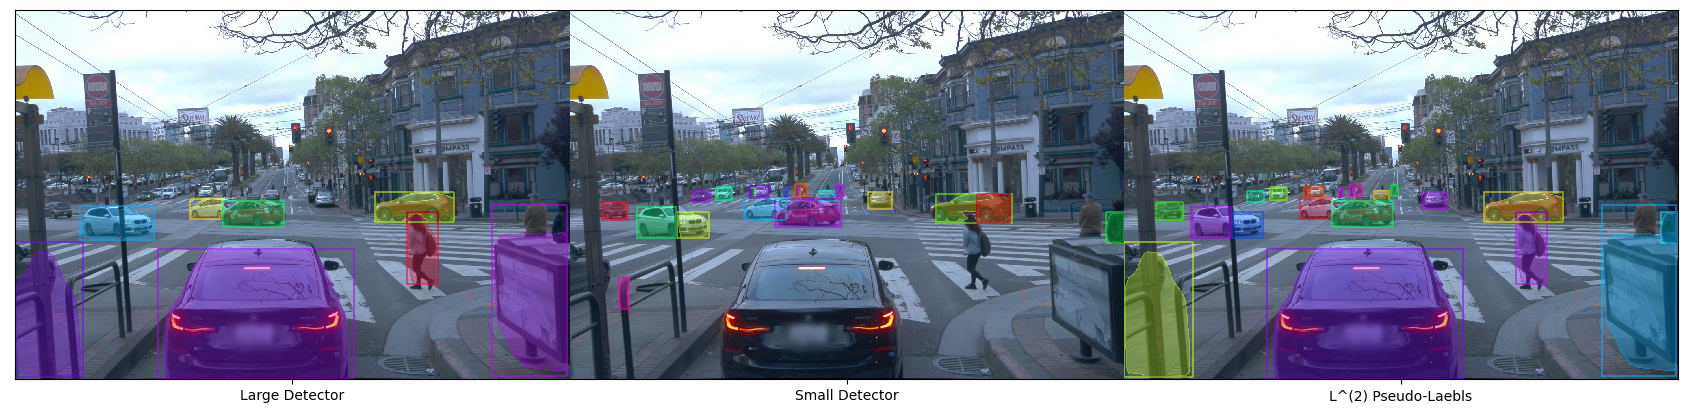

In [6]:
from moduv.pseudo_labels.save_agg_pred import aggregate_masks

ST_L_CONF_THRD = 0.9
ST_S_CONF_THRD = 0.8
MATCH_IOU_THRD = 0.5
SELF_FILT_THRD = 0.75
CROSS_FILT_THRD = 0.5

# Load model after Large2Small self-training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_L = Model(backbone_weights='moco').eval().to(device)
model_L.load('./ckpts/moduv_l2s_l.pth')
model_L.set_score_thrd(ST_L_CONF_THRD)

model_S = Model(backbone_weights='moco').eval().to(device)
model_S.load('./ckpts/moduv_l2s_s.pth')
model_S.set_score_thrd(ST_S_CONF_THRD)

# Compute L2
with torch.no_grad():
    output_L = model_L(read_img(img_path))[0][0]
    output_S = model_S(read_img(img_path))[0][0]
L2 = aggregate_masks(output_L, output_S, match_thrd=MATCH_IOU_THRD, self_filt_thrd=SELF_FILT_THRD, cross_filt_thrd=CROSS_FILT_THRD)

L_only_vis = visualize_ann(img, output_L, bool_words=False)
S_only_vis = visualize_ann(img, output_S, bool_words=False)
L2_vis = visualize_ann(img, L2, bool_words=False)
show_vis([L_only_vis, S_only_vis, L2_vis], ['Large Detector', 'Small Detector', 'L^(2) Pseudo-Laebls'])



#### Visualizing $L_i^{(0)}$, $L_i^{(1)}$, $L_i^{(2)}$ to reproduce Fig. 2

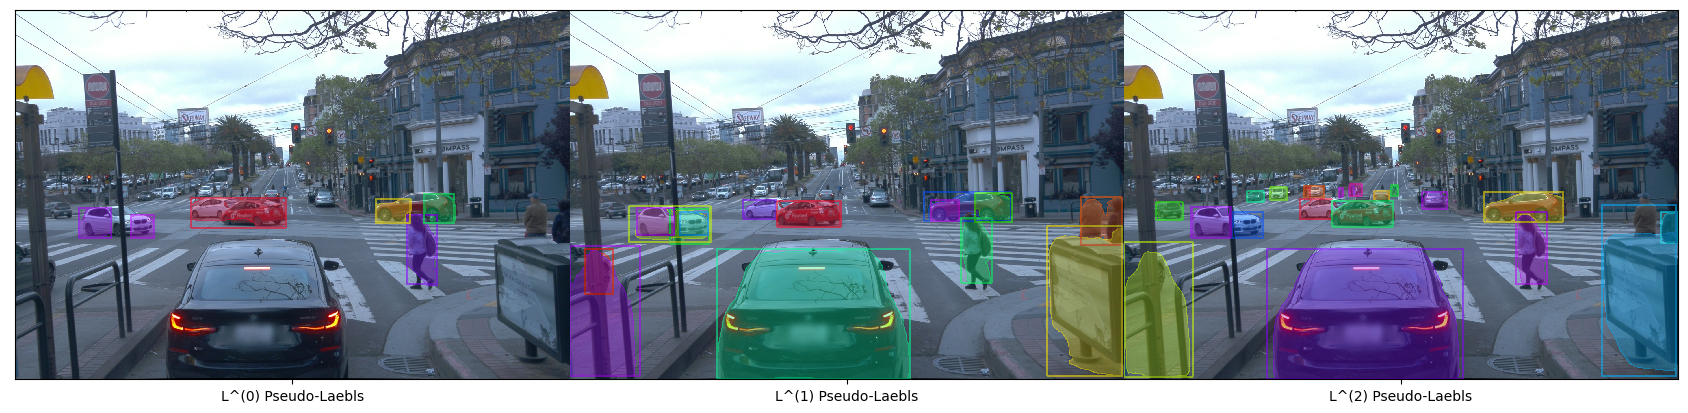

In [7]:
show_vis([L0_vis, L1_vis, L2_vis], ['L^(0) Pseudo-Laebls', 'L^(1) Pseudo-Laebls', 'L^(2) Pseudo-Laebls'])